In [1]:
# =============================================================================
# 1. CẤU HÌNH HỆ THỐNG
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from graphdatascience import GraphDataScience
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve
from collections import defaultdict
import warnings
import random

# PyTorch Geometric imports
import torch
from torch_geometric.nn import HGTConv, Linear
from torch_geometric.data import HeteroData
import torch.nn.functional as F

warnings.filterwarnings('ignore')

NEO4J_URI = "bolt://localhost:7687"
NEO4J_AUTH = ("neo4j", "12345678")
CSV_PATH = "Data/data_end.csv"
RANDOM_SEED = 42

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")

🖥️ Using device: cpu


In [2]:
# =============================================================================
# 2. HÀM CHUẨN HÓA
# =============================================================================
def canonicalize_smiles(smi):
    """Chuyển mọi biến thể SMILES về dạng chuẩn duy nhất của RDKit"""
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True, isomericSmiles=False) 
        return None
    except:
        return None

In [3]:
# =============================================================================
# 3. HGT MODEL DEFINITION
# =============================================================================
class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers, metadata):
        super().__init__()
        
        # Input projection cho mỗi node type
        self.lin_dict = torch.nn.ModuleDict()
        for node_type in metadata[0]:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)
        
        # HGT Convolution layers
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, metadata, num_heads)
            self.convs.append(conv)
        
        # Output projection
        self.lin = Linear(hidden_channels, out_channels)
        
    def forward(self, x_dict, edge_index_dict):
        # Input projection
        x_dict = {
            node_type: self.lin_dict[node_type](x).relu_()
            for node_type, x in x_dict.items()
        }
        
        # HGT layers
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}
        
        return x_dict


In [ ]:
# =============================================================================
# 4. LOAD DỮ LIỆU & KG EMBEDDING (HGT VERSION)
# =============================================================================
def load_and_prep_csv(path):
    print("📖 Đang đọc file CSV...")
    df = pd.read_csv(path)
    
    if 'Final_Label' not in df.columns and 'Label' in df.columns:
        df['Final_Label'] = df['Label']
    
    df = df[df['Final_Label'] != 'Uncertain']
    df['Label_Num'] = df['Final_Label'].apply(lambda x: 1 if str(x).lower() == 'active' else 0)
    
    print("🔄 Đang chuẩn hóa SMILES trong CSV...")
    df['SMILES_Key'] = df['SMILES'].apply(canonicalize_smiles)
    df = df.dropna(subset=['SMILES_Key']).drop_duplicates(subset=['SMILES_Key'])
    
    print(f"✅ CSV Sạch: {len(df)} dòng.")
    return df

def get_kg_embedding_hgt(gds):
    print("\n🧠 Đang chạy HGT trên Neo4j (KANO Architecture)...")

    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print("\n🧠 Đang chạy HGT trên Neo4j (KANO Architecture)...")
    
    # ============ BƯỚC 1: XUẤT TOÀN BỘ GRAPH TỪ NEO4J ============
    print("   -> Đang xuất đồ thị từ Neo4j...")
    
    # Lấy tất cả nodes theo từng loại (CHỈ EXPERIMENTAL)
    molecules = gds.run_cypher("""
        MATCH (n:Molecule) WHERE n.is_virtual = false
        RETURN id(n) as node_id, n.smiles as smiles
    """)
    
    scaffolds = gds.run_cypher("""
        MATCH (n:Scaffold)
        RETURN id(n) as node_id, n.smiles as smiles
    """)
    
    targets = gds.run_cypher("""
        MATCH (n:Target)
        RETURN id(n) as node_id, n.name as name
    """)
    
    functional_groups = gds.run_cypher("""
        MATCH (n:FunctionalGroup)
        RETURN id(n) as node_id, n.name as name
    """)
    
    warheads = gds.run_cypher("""
        MATCH (n:Warhead)
        RETURN id(n) as node_id, n.name as name
    """)
    
    moas = gds.run_cypher("""
        MATCH (n:MoA)
        RETURN id(n) as node_id, n.name as name
    """)
    
    print(f"      📊 Molecules: {len(molecules)}, Scaffolds: {len(scaffolds)}, Targets: {len(targets)}")
    print(f"      📊 FunctionalGroups: {len(functional_groups)}, Warheads: {len(warheads)}, MoAs: {len(moas)}")
    
    # Lấy tất cả edges (ALLOW-LIST để tránh label leakage: POTENT_AGAINST được tạo từ activity label)
    edges = gds.run_cypher("""
        MATCH (m)-[r]->(n)
        WHERE ((m:Molecule AND m.is_virtual = false) OR (n:Molecule AND n.is_virtual = false))
          AND type(r) IN ['HAS_SCAFFOLD','HAS_FUNCTIONAL_GROUP','CONTAINS_WARHEAD','ACTS_VIA','TESTED_AGAINST']
        RETURN id(m) as src, type(r) as rel_type, id(n) as dst, 
               labels(m)[0] as src_type, labels(n)[0] as dst_type
    """)
    
    print(f"      📊 Total edges: {len(edges)}")
    
    # ============ BƯỚC 2: XÂY DỰNG HETERODATA ============
    print("   -> Đang xây dựng HeteroData...")
    data = HeteroData()
    
    # Tạo mapping: Neo4j node_id -> local index
    mol_map = {row['node_id']: i for i, row in molecules.iterrows()}
    scaf_map = {row['node_id']: i for i, row in scaffolds.iterrows()}
    targ_map = {row['node_id']: i for i, row in targets.iterrows()}
    fg_map = {row['node_id']: i for i, row in functional_groups.iterrows()}
    wh_map = {row['node_id']: i for i, row in warheads.iterrows()}
    moa_map = {row['node_id']: i for i, row in moas.iterrows()}
    
    # Tạo features khởi tạo (random embeddings) - THAY ĐỔI: 64 -> 128 để match với hidden_channels
    embed_dim = 128
    data['Molecule'].x = torch.randn(len(molecules), embed_dim)
    data['Scaffold'].x = torch.randn(len(scaffolds), embed_dim)
    data['Target'].x = torch.randn(len(targets), embed_dim)
    data['FunctionalGroup'].x = torch.randn(len(functional_groups), embed_dim)
    data['Warhead'].x = torch.randn(len(warheads), embed_dim)
    data['MoA'].x = torch.randn(len(moas), embed_dim)
    
    # Tạo edge_index cho từng loại relationship
    edge_dict = defaultdict(lambda: [[], []])
    node_type_map = {
        'Molecule': mol_map,
        'Scaffold': scaf_map,
        'Target': targ_map,
        'FunctionalGroup': fg_map,
        'Warhead': wh_map,
        'MoA': moa_map
    }
    
    for _, row in edges.iterrows():
        src_id = row['src']
        dst_id = row['dst']
        src_type = row['src_type']
        dst_type = row['dst_type']
        rel_type = row['rel_type']
        
        # Lấy mapping tương ứng
        if src_type not in node_type_map or dst_type not in node_type_map:
            continue
            
        src_idx_map = node_type_map[src_type]
        dst_idx_map = node_type_map[dst_type]
        
        if src_id not in src_idx_map or dst_id not in dst_idx_map:
            continue
        
        src_idx = src_idx_map[src_id]
        dst_idx = dst_idx_map[dst_id]
        
        # Thêm edge (bidirectional cho undirected graph)
        key = (src_type, rel_type, dst_type)
        edge_dict[key][0].append(src_idx)
        edge_dict[key][1].append(dst_idx)
        
        # Reverse edge
        rev_key = (dst_type, f"rev_{rel_type}", src_type)
        edge_dict[rev_key][0].append(dst_idx)
        edge_dict[rev_key][1].append(src_idx)
    
    # Convert to edge_index tensors
    for key, (srcs, dsts) in edge_dict.items():
        data[key].edge_index = torch.tensor([srcs, dsts], dtype=torch.long)
    
    print(f"      ✅ HeteroData created with {len(data.node_types)} node types and {len(data.edge_types)} edge types")
    
    # ============ BƯỚC 3: TRAIN HGT MODEL ============
    print("   -> Training HGT Model...")
    
    model = HGT(
        hidden_channels=128,
        out_channels=128,
        num_heads=4,
        num_layers=2,
        metadata=data.metadata()
    ).to(device)
    
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
    
    # Self-supervised training: reconstruct node features
    model.train()
    for epoch in range(50):
        optimizer.zero_grad()
        
        out_dict = model(data.x_dict, data.edge_index_dict)
        
        # Loss: MSE reconstruction
        loss = 0
        for node_type in data.node_types:
            loss += F.mse_loss(out_dict[node_type], data[node_type].x)
        
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"      Epoch {epoch+1}/50, Loss: {loss.item():.4f}")
    
    # ============ BƯỚC 4: EXTRACT EMBEDDINGS ============
    print("   -> Extracting Embeddings...")
    model.eval()
    with torch.no_grad():
        embeddings = model(data.x_dict, data.edge_index_dict)
        mol_embeddings = embeddings['Molecule'].cpu().numpy()
    
    # ============ BƯỚC 5: TẠO DATAFRAME KẾT QUẢ ============
    df_emb = molecules.copy()
    df_emb['embedding'] = list(mol_embeddings)
    
    # Chuẩn hóa SMILES
    df_emb['SMILES_Key'] = df_emb['smiles'].apply(canonicalize_smiles)
    df_emb = df_emb.dropna(subset=['SMILES_Key']).drop_duplicates(subset=['SMILES_Key'])
    
    print(f"✅ HGT Embeddings: {len(df_emb)} dòng (CHỈ experimental).")
    return df_emb[['SMILES_Key', 'embedding', 'smiles']].rename(columns={'smiles': 'SMILES'})


In [5]:
# =============================================================================
# 5. CHIA TẬP DỮ LIỆU & FEATURES (KHÔNG THAY ĐỔI)
# =============================================================================
def scaffold_split_balanced(df, smiles_col='SMILES', test_size=0.2):
    print("\n🔄 Đang thực hiện Balanced Scaffold Split...")
    scaffold_dict = defaultdict(list)
    for idx, smi in enumerate(df[smiles_col]):
        mol = Chem.MolFromSmiles(smi)
        try: 
            scaf = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False) if mol else "Generic"
        except: 
            scaf = "Generic"
        scaffold_dict[scaf].append(idx)
            
    groups = sorted(scaffold_dict.values(), key=len, reverse=True)
    
    train_inds, test_inds = [], []
    target_test_size = len(df) * test_size
    
    for group in groups:
        if len(test_inds) + len(group) <= target_test_size + 50:
            test_inds.extend(group)
        else:
            train_inds.extend(group)
            
    print(f"   ► Train set: {len(train_inds)} | Test set: {len(test_inds)}")
    return df.iloc[train_inds].copy(), df.iloc[test_inds].copy()

def get_ecfp4(smiles_list):
    print("🧪 Tạo ECFP4 Fingerprints...")
    return np.array([np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=1024)) 
                     for s in smiles_list])

def calculate_max_sim(train_smiles, test_smiles):
    print("🔍 Tính toán độ khó (Tanimoto Similarity)...")
    train_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 2) for x in train_smiles]
    test_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 2) for x in test_smiles]
    
    max_sims = []
    for tfp in test_fps:
        sims = DataStructs.BulkTanimotoSimilarity(tfp, train_fps)
        max_sims.append(max(sims))
    return np.array(max_sims)

def analyze_results(y_true, y_pred_ecfp, y_pred_kg, sims):
    zones = {
        '🟢 KHÓ (Novelty < 0.4)': (sims < 0.4),
        '🟡 VỪA (0.4 - 0.8)': (sims >= 0.4) & (sims < 0.8),
        '🔴 DỄ (Mem > 0.8)': (sims >= 0.8)
    }
    
    results_list = []
    print("\n" + "="*85)
    print(f"{'VÙNG ĐỘ KHÓ':<25} | {'SỐ LƯỢNG':<10} | {'ACC (ECFP4)':<12} | {'ACC (KG-HGT)':<12} | {'DELTA (HGT-ECFP)':<15}")
    print("-" * 85)
    
    for zone_name, mask in zones.items():
        count = np.sum(mask)
        if count == 0:
            print(f"{zone_name:<25} | 0          | N/A          | N/A          | N/A")
            continue
            
        sub_y = y_true[mask]
        acc_ecfp = accuracy_score(sub_y, y_pred_ecfp[mask])
        acc_kg = accuracy_score(sub_y, y_pred_kg[mask])
        delta = acc_kg - acc_ecfp
        
        sign = "+" if delta > 0 else ""
        print(f"{zone_name:<25} | {count:<10} | {acc_ecfp:.4f}       | {acc_kg:.4f}       | {sign}{delta:.4f}")
        results_list.append({'Zone': zone_name, 'ECFP4': acc_ecfp, 'KG': acc_kg})
        
    overall_ecfp = accuracy_score(y_true, y_pred_ecfp)
    overall_kg = accuracy_score(y_true, y_pred_kg)
    
    print("-" * 85)
    print(f"{'TỔNG HỢP (ALL)':<25} | {len(y_true):<10} | {overall_ecfp:.4f}       | {overall_kg:.4f}       | {overall_kg-overall_ecfp:.4f}")
    print("="*85)
    return results_list

📖 Đang đọc file CSV...
🔄 Đang chuẩn hóa SMILES trong CSV...
✅ CSV Sạch: 5508 dòng.

🧠 Đang chạy HGT trên Neo4j (KANO Architecture)...

🧠 Đang chạy HGT trên Neo4j (KANO Architecture)...
   -> Đang xuất đồ thị từ Neo4j...
      📊 Molecules: 5644, Scaffolds: 2269, Targets: 3
      📊 FunctionalGroups: 83, Warheads: 6, MoAs: 2
      📊 Total edges: 103256
   -> Đang xây dựng HeteroData...
      ✅ HeteroData created with 6 node types and 12 edge types
   -> Training HGT Model...
      Epoch 10/50, Loss: 5.4035
      Epoch 20/50, Loss: 4.9211
      Epoch 30/50, Loss: 4.6304
      Epoch 40/50, Loss: 4.4854
      Epoch 50/50, Loss: 4.3997
   -> Extracting Embeddings...
✅ HGT Embeddings: 5508 dòng (CHỈ experimental).

🔄 Đang Merge dữ liệu...
✅ Dữ liệu sẵn sàng để train: 5508 dòng.

🔄 Đang thực hiện Balanced Scaffold Split...
   ► Train set: 4357 | Test set: 1151
🧪 Tạo ECFP4 Fingerprints...
🧪 Tạo ECFP4 Fingerprints...
🔍 Tính toán độ khó (Tanimoto Similarity)...

🥊 Training ECFP4 Model (Random Fore

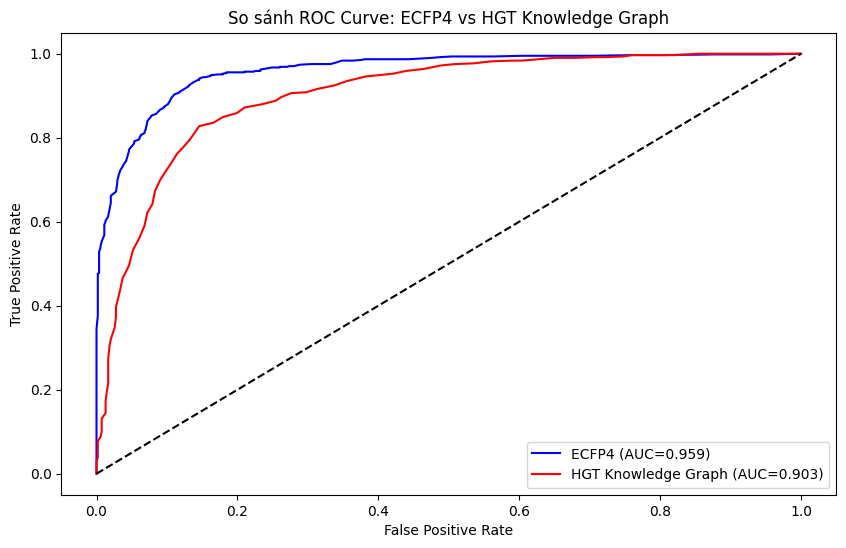

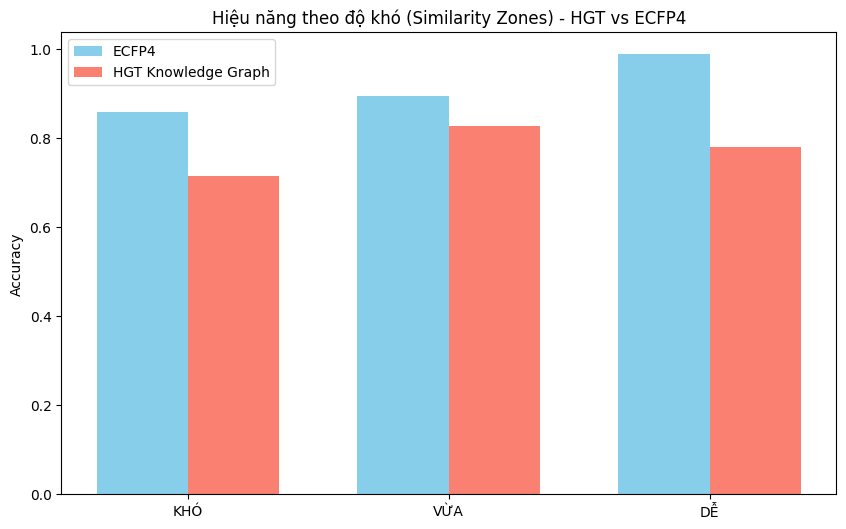

In [6]:
# =============================================================================
# 6. MAIN EXECUTION
# =============================================================================
if __name__ == "__main__":
    # --- BƯỚC 1: LOAD VÀ MERGE ---
    df = load_and_prep_csv(CSV_PATH)
    gds = GraphDataScience(NEO4J_URI, auth=NEO4J_AUTH)
    
    # SỬ DỤNG HGT THAY VÌ GRAPHSAGE
    kg_emb = get_kg_embedding_hgt(gds)
    
    # Merge bằng cột khóa chuẩn hóa 'SMILES_Key'
    print("\n🔄 Đang Merge dữ liệu...")
    df_full = pd.merge(df, kg_emb[['SMILES_Key', 'embedding']], on='SMILES_Key', how='inner')
    print(f"✅ Dữ liệu sẵn sàng để train: {len(df_full)} dòng.")
    
    if len(df_full) < len(df) * 0.95:
        print("⚠️ Cảnh báo: Vẫn mất dữ liệu. Hãy kiểm tra lại Database Neo4j.")

    # --- BƯỚC 2: CHIA TẬP TRAIN/TEST ---
    train_df, test_df = scaffold_split_balanced(df_full)
    
    y_train = train_df['Label_Num'].values
    y_test = test_df['Label_Num'].values
    
    # --- BƯỚC 3: TẠO FEATURE ---
    X_ecfp_train = get_ecfp4(train_df['SMILES'])
    X_ecfp_test = get_ecfp4(test_df['SMILES'])
    
    X_kg_train = np.stack(train_df['embedding'].values)
    X_kg_test = np.stack(test_df['embedding'].values)
    
    sims = calculate_max_sim(train_df['SMILES'], test_df['SMILES'])
    
    # --- BƯỚC 4: TRAINING ---
    print("\n🥊 Training ECFP4 Model (Random Forest)...")
    rf_ecfp = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
    rf_ecfp.fit(X_ecfp_train, y_train)
    y_pred_ecfp = rf_ecfp.predict(X_ecfp_test)
    y_prob_ecfp = rf_ecfp.predict_proba(X_ecfp_test)[:, 1]
    
    print("🥊 Training KG-HGT Model (Random Forest)...")
    rf_kg = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
    rf_kg.fit(X_kg_train, y_train)
    y_pred_kg = rf_kg.predict(X_kg_test)
    y_prob_kg = rf_kg.predict_proba(X_kg_test)[:, 1]
    
    # --- BƯỚC 5: BÁO CÁO ---
    res_data = analyze_results(y_test, y_pred_ecfp, y_pred_kg, sims)
    
    # ROC Curve
    plt.figure(figsize=(10, 6))
    fpr_e, tpr_e, _ = roc_curve(y_test, y_prob_ecfp)
    fpr_k, tpr_k, _ = roc_curve(y_test, y_prob_kg)
    
    plt.plot(fpr_e, tpr_e, label=f'ECFP4 (AUC={roc_auc_score(y_test, y_prob_ecfp):.3f})', color='blue')
    plt.plot(fpr_k, tpr_k, label=f'HGT Knowledge Graph (AUC={roc_auc_score(y_test, y_prob_kg):.3f})', color='red')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('So sánh ROC Curve: ECFP4 vs HGT Knowledge Graph')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    # Bar Chart
    if res_data:
        labels = [d['Zone'].split(' ')[1] for d in res_data]
        ecfp_scores = [d['ECFP4'] for d in res_data]
        kg_scores = [d['KG'] for d in res_data]
        
        x = np.arange(len(labels))
        width = 0.35
        
        plt.figure(figsize=(10, 6))
        plt.bar(x - width/2, ecfp_scores, width, label='ECFP4', color='skyblue')
        plt.bar(x + width/2, kg_scores, width, label='HGT Knowledge Graph', color='salmon')
        plt.xticks(x, labels)
        plt.ylabel('Accuracy')
        plt.title('Hiệu năng theo độ khó (Similarity Zones) - HGT vs ECFP4')
        plt.legend()
        plt.show()

Number of unique scaffolds (>=2 molecules): 628
===== Scaffold Detection Rate =====
Total scaffold pairs: 121975

ECFP4:
  Detected pairs : 30646
  Detection rate : 0.251

Knowledge Graph:
  Detected pairs : 14240
  Detection rate : 0.117


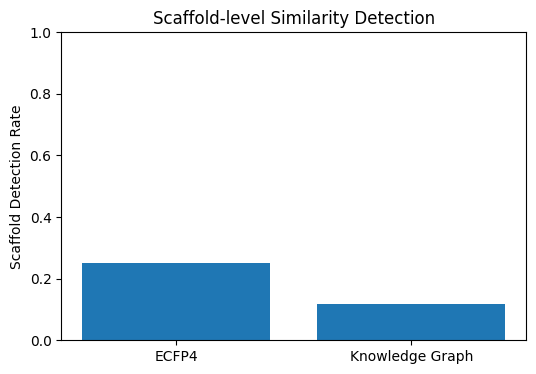

In [7]:
import itertools
import numpy as np
from collections import defaultdict

from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import DataStructs

from sklearn.metrics.pairwise import cosine_similarity

def get_murcko_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    if scaffold is None:
        return None
    return Chem.MolToSmiles(scaffold)

# Generate ECFP4 fingerprints
from rdkit.Chem import AllChem

# Use SMILES from kg_emb DataFrame
smiles_list = kg_emb['SMILES'].tolist()

ecfp4_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=2048) for s in smiles_list]

scaffolds = [get_murcko_scaffold(s) for s in smiles_list]

scaffold_groups = defaultdict(list)

for idx, scaf in enumerate(scaffolds):
    if scaf is not None:
        scaffold_groups[scaf].append(idx)

# Chỉ giữ scaffold có ít nhất 2 phân tử
scaffold_groups = {
    scaf: idxs for scaf, idxs in scaffold_groups.items()
    if len(idxs) >= 2
}

print(f"Number of unique scaffolds (>=2 molecules): {len(scaffold_groups)}")

def scaffold_detection_rate_ecfp4(
    scaffold_groups,
    fingerprints,
    sim_threshold=0.5
):
    detected = 0
    total = 0

    for indices in scaffold_groups.values():
        for i, j in itertools.combinations(indices, 2):
            total += 1
            sim = DataStructs.TanimotoSimilarity(
                fingerprints[i],
                fingerprints[j]
            )
            if sim >= sim_threshold:
                detected += 1

    rate = detected / total if total > 0 else 0
    return rate, detected, total

def scaffold_detection_rate_kg(
    scaffold_groups,
    embeddings,
    sim_threshold=0.7
):
    detected = 0
    total = 0

    for indices in scaffold_groups.values():
        for i, j in itertools.combinations(indices, 2):
            total += 1
            # Convert embedding to numpy array if it's a list
            emb_i = np.array(embeddings[i]) if isinstance(embeddings[i], list) else embeddings[i]
            emb_j = np.array(embeddings[j]) if isinstance(embeddings[j], list) else embeddings[j]
            sim = cosine_similarity(
                emb_i.reshape(1, -1),
                emb_j.reshape(1, -1)
            )[0, 0]
            if sim >= sim_threshold:
                detected += 1

    rate = detected / total if total > 0 else 0
    return rate, detected, total

# Extract embeddings from kg_emb DataFrame
kg_embeddings = [np.array(emb) for emb in kg_emb['embedding'].values]

# ECFP4 detection rate
ecfp4_rate, ecfp4_detected, total_pairs = scaffold_detection_rate_ecfp4(
    scaffold_groups,
    ecfp4_fps,
    sim_threshold=0.5
)

# KG detection rate
kg_rate, kg_detected, _ = scaffold_detection_rate_kg(
    scaffold_groups,
    kg_embeddings,
    sim_threshold=0.7
)

print("===== Scaffold Detection Rate =====")
print(f"Total scaffold pairs: {total_pairs}")
print()
print(f"ECFP4:")
print(f"  Detected pairs : {ecfp4_detected}")
print(f"  Detection rate : {ecfp4_rate:.3f}")
print()
print(f"Knowledge Graph:")
print(f"  Detected pairs : {kg_detected}")
print(f"  Detection rate : {kg_rate:.3f}")

import matplotlib.pyplot as plt

methods = ['ECFP4', 'Knowledge Graph']
rates = [ecfp4_rate, kg_rate]

plt.figure(figsize=(6,4))
plt.bar(methods, rates)
plt.ylim(0, 1)
plt.ylabel("Scaffold Detection Rate")
plt.title("Scaffold-level Similarity Detection")
plt.show()


In [8]:
# =========================================================
# FALSE POSITIVE DEBUGGING: ECFP4 vs KNOWLEDGE GRAPH
# =========================================================

import numpy as np
import pandas as pd
import itertools
from collections import defaultdict

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Scaffolds import MurckoScaffold

from sklearn.metrics.pairwise import cosine_similarity

# ---------------------------------------------------------
# 1. Tạo DataFrame debug (align theo test set)
# ---------------------------------------------------------

debug_df = df_full.iloc[test_df.index].copy()

debug_df["y_true"] = y_test
debug_df["pred_ecfp"] = y_pred_ecfp
debug_df["pred_kg"] = y_pred_kg
debug_df["prob_ecfp"] = y_prob_ecfp
debug_df["prob_kg"] = y_prob_kg

# ---------------------------------------------------------
# 2. Xác định các nhóm False Positive
# ---------------------------------------------------------

# False Positive = dự đoán Active (1) nhưng thực tế Inactive (0)
fp_ecfp = debug_df[
    (debug_df["y_true"] == 0) &
    (debug_df["pred_ecfp"] == 1)
]

fp_kg = debug_df[
    (debug_df["y_true"] == 0) &
    (debug_df["pred_kg"] == 1)
]

fp_ecfp_only = debug_df[
    (debug_df["y_true"] == 0) &
    (debug_df["pred_ecfp"] == 1) &
    (debug_df["pred_kg"] == 0)
]

fp_kg_only = debug_df[
    (debug_df["y_true"] == 0) &
    (debug_df["pred_kg"] == 1) &
    (debug_df["pred_ecfp"] == 0)
]

fp_both = debug_df[
    (debug_df["y_true"] == 0) &
    (debug_df["pred_ecfp"] == 1) &
    (debug_df["pred_kg"] == 1)
]

print("===== FALSE POSITIVE SUMMARY =====")
print(f"FP ECFP4 total  : {len(fp_ecfp)}")
print(f"FP KG total     : {len(fp_kg)}")
print(f"FP ECFP4 only   : {len(fp_ecfp_only)}")
print(f"FP KG only      : {len(fp_kg_only)}")
print(f"FP both         : {len(fp_both)}")

# ---------------------------------------------------------
# 3. Murcko Scaffold cho các FP
# ---------------------------------------------------------

def get_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    scaf = MurckoScaffold.GetScaffoldForMol(mol)
    return Chem.MolToSmiles(scaf) if scaf else None

for df_fp in [fp_ecfp_only, fp_kg_only, fp_both]:
    df_fp["scaffold"] = df_fp["SMILES"].apply(get_scaffold)

# ---------------------------------------------------------
# 4. Similarity với tập train
# ---------------------------------------------------------

# ---- ECFP4: max Tanimoto to train ----
# First, generate ECFP4 fingerprints for the molecules
from rdkit.Chem import AllChem

def get_ecfp4_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)

# Generate fingerprints for train set
train_fps = [get_ecfp4_fp(smiles) for smiles in train_df["SMILES"]]
train_fps = [fp for fp in train_fps if fp is not None]

def max_tanimoto_to_train(smiles, train_fingerprints):
    fp = get_ecfp4_fp(smiles)
    if fp is None:
        return 0.0
    sims = [DataStructs.TanimotoSimilarity(fp, train_fp) for train_fp in train_fingerprints]
    return max(sims) if sims else 0.0

fp_ecfp_only["max_sim_train"] = [
    max_tanimoto_to_train(fp_ecfp_only.loc[i, "SMILES"], train_fps)
    for i in fp_ecfp_only.index
]

# ---- KG: max cosine similarity to train ----
# Extract KG embeddings from train set
train_kg_emb = np.array([np.array(emb) if isinstance(emb, list) else emb for emb in train_df["embedding"]])

def max_cosine_to_train(emb, train_embs):
    if isinstance(emb, list):
        emb = np.array(emb)
    sims = cosine_similarity(
        emb.reshape(1, -1),
        train_embs
    )
    return sims.max()

fp_kg_only["max_sim_train"] = [
    max_cosine_to_train(fp_kg_only.loc[i, "embedding"], train_kg_emb)
    for i in fp_kg_only.index
]

# ---------------------------------------------------------
# 5. Case study: các FP confident nhất
# ---------------------------------------------------------

print("\n===== TOP FALSE POSITIVE (ECFP4 ONLY) =====")
display(
    fp_ecfp_only.sort_values(
        "prob_ecfp", ascending=False
    )[["SMILES", "prob_ecfp", "prob_kg", "max_sim_train", "scaffold"]].head(5)
)

print("\n===== TOP FALSE POSITIVE (KG ONLY) =====")
display(
    fp_kg_only.sort_values(
        "prob_kg", ascending=False
    )[["SMILES", "prob_kg", "prob_ecfp", "max_sim_train", "scaffold"]].head(5)
)

# ---------------------------------------------------------
# 6. Thống kê scaffold gây FP nhiều nhất
# ---------------------------------------------------------

print("\n===== MOST COMMON FP SCAFFOLDS (ECFP4) =====")
display(
    fp_ecfp_only["scaffold"].value_counts().head(5)
)

print("\n===== MOST COMMON FP SCAFFOLDS (KG) =====")
display(
    fp_kg_only["scaffold"].value_counts().head(5)
)

# =========================================================
# END OF FALSE POSITIVE DEBUGGING
# =========================================================


===== FALSE POSITIVE SUMMARY =====
FP ECFP4 total  : 71
FP KG total     : 138
FP ECFP4 only   : 45
FP KG only      : 112
FP both         : 26

===== TOP FALSE POSITIVE (ECFP4 ONLY) =====


,SMILES,prob_ecfp,prob_kg,max_sim_train,scaffold
441,CC1=CC2=C(C=C1)N=CN=C2NC3=CC(=CC=C3)Br,0.90,0.43,0.659091,c1ccc(Nc2ncnc3ccccc23)cc1
1095,COc1cc2ncnc(Nc3cccc(C#CCCCO)c3)c2cc1OC,0.83,0.43,0.703704,c1ccc(Nc2ncnc3ccccc23)cc1
2762,COC/C=C/C(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,0.80,0.43,0.718750,c1ccc(Nc2ncnc3ccccc23)cc1
3222,COC1=C(C2=C(C=C1)N=CN=C2NC3=CC(=CC=C3)Br)OC,0.79,0.44,0.596154,c1ccc(Nc2ncnc3ccccc23)cc1
2911,C=CCSSCCC(=O)OCCCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC,0.79,0.28,0.539474,c1ccc(Nc2ncnc3ccccc23)cc1



===== TOP FALSE POSITIVE (KG ONLY) =====


,SMILES,prob_kg,prob_ecfp,max_sim_train,scaffold
4197,CCOC(=O)Nc1ccc(Nc2ncnc3cc(OC)c(OC)cc23)cc1C.Cl,0.91,0.36,0.779559,c1ccc(Nc2ncnc3ccccc23)cc1
1789,COC(=O)Nc1ccc(Nc2ncnc3cc(OC)c(OC)cc23)cc1C.Cl,0.87,0.41,0.742627,c1ccc(Nc2ncnc3ccccc23)cc1
3406,COC(=O)Nc1ccc(Nc2ncnc3cc(OC)c(OC)cc23)cc1C,0.87,0.42,0.699726,c1ccc(Nc2ncnc3ccccc23)cc1
2154,CCOC(=O)Nc1cc(Nc2ncnc3cc(OC)c(OC)cc23)ccc1C.Cl,0.86,0.39,0.787064,c1ccc(Nc2ncnc3ccccc23)cc1
4732,CCOC(=O)Nc1ccc(Nc2ncnc3cc(OC)c(OC)cc23)cc1C,0.83,0.38,0.760324,c1ccc(Nc2ncnc3ccccc23)cc1



===== MOST COMMON FP SCAFFOLDS (ECFP4) =====


scaffold
c1ccc(Nc2ncnc3ccccc23)cc1                   28
c1ccc(Nc2ncnc3ccncc23)cc1                   14
c1ccc(Nc2ccnc3ccccc23)cc1                    1
c1ccc(CNc2ncnc3sc(-c4ccccc4)cc23)cc1         1
c1ccc(Oc2ccnc(Nc3ccc(N4CCNCC4)cc3)n2)cc1     1
Name: count, dtype: int64


===== MOST COMMON FP SCAFFOLDS (KG) =====


scaffold
c1ccc(Nc2ccnc3ccccc23)cc1                                    31
c1ccc(Nc2ncnc3ccccc23)cc1                                    24
O=C(Cc1ccccc1)Nc1cc(-c2[nH]c3c(c2Nc2ccccc2)C(=O)NCC3)ccn1    24
c1ccccc1                                                      8
c1ccc(Nc2ncnc3c2NCc2ccccc2O3)cc1                              7
Name: count, dtype: int64

In [9]:
print("SMILES:", len(smiles_list))
print("ECFP4 :", len(X_ecfp4_aligned))
print("KG emb:", len(kg_emb))


SMILES: 5508


NameError: name 'X_ecfp4_aligned' is not defined